# **Tutorial 1. Dealing with bigWig Data**

BigWig files are compressed binary files developed by UCSC. They are primarily used in bioinformatics to store and visualise genomic data in UCSC's Genome Browser. The files are indexed allowing access to specific genomic regions without having to access or download the whole genome. Accessing and converting their data for machine learning purposes can be quite confusing at times. UCSC has their own programs to extract genomic data from bigWigs, however python libraries like pyBigWig also exist, making converting bigWigs to numpy arrays much easier. 

This tutorial begins using UCSC's programs to quickly understand the genomic data within BigWigs, before using the pyBigWig library to simply extract BigWig data. 

The final part of this tutorial uses the pyBigWig library to load, filter, and split BigWig data into training, validation, and test sets. The data consists of signal p-values from ChIP-seq experiments, processed using the MACS2 tool, which outputs signals averaged over 25 base pair bins. We will re-average these signals to a resolution of 32 base pairs (based on model requirements). Additionally, we will implement threshold-based filtering and consistent data splits to ready the data for a model.

This tutorial uses ChIP-seq histone data from two experiments from the Encode project with accession ids: <br>
[ENCSR817LUF](https://www.encodeproject.org/experiments/ENCSR817LUF/) <br>
[ENCSR958TSO](https://www.encodeproject.org/experiments/ENCSR958TSO/)

Note: <br>
This tutorial is hosted by [mybinder.org](mybinder.org) to provide an interactive experience. Due to computational limitations, especially with regards to machine learning models, genomic data is accessed via url. Furthermore, this tutorial only uses data on one chromosome. When training models in a real-world setting, it is recommended that bigWigs be downloaded locally (for computational efficiency) and models are trained using multiple chromosomes depending on the model's aim.

In [1]:
import numpy as np
import pyBigWig
import matplotlib.pyplot as plt
import pandas as pd
import random
import requests

## **UCSC Programs**

In order to get a quick sense of the data in a bigWig file, lets use UCSC's programs. <br><br>
UCSC's programs to access information from bigWigs include:

**bigWigInfo** — prints out information about a bigWig file. <br><br>
**bigWigSummary** — extracts summary information from a bigWig file. <br><br>

Additional UCSC programs include: <br> <br>
- bigWigToWig  <br><br>
- bigWigToBedGraph <br><br>
These programs allow for converting bigWig files into other formats such as .wig and .bedgraph if needed. <br><br>

Available to download from "https://genome.ucsc.edu/goldenPath/help/bigWig.html". The executable programs are within this tutorial's github repository.

Running the programs by themselves print out their help/usage statements.

In [2]:
#bigWigInfomac (mac environment)
#bigWigInfo (linux - binder/online environment)

#!./bigWigInfo
#!./bigWigSummary

## bigWigInfo
**BigWig files (.bw) can be accessed via url**. For example, if you look at genomic data from the [Encode Project](https://www.encodeproject.org), processed data such as p-values and fold-change data are in bigWig format. The bigWig file is available to be downloaded or accessed from "https://www.encodeproject.org/files/[experiment]/@@download/[experiment].bigWig", where [experiment] is the accession id of the experiment. We can parse the indexed data without having to download the files themselves.

Take the accession id [ENCSR817LUF](https://www.encodeproject.org/experiments/ENCSR817LUF/). This is the same experiment that we visualised earlier using the UCSC Genome Browser (1.2.2 Example Data Representations:). Recall it was a ChIP-seq experiment targeting the H3K36me3 histone modification in brain tissue.

The bigWig file containing the p-value for signal strength for this experiment has the accession id [ENCFF601VTB](https://www.encodeproject.org/files/ENCFF601VTB/). The specific accession id's for bigWig files can be found in the "Association graph" or "File details" tab from any experiment ([ENCSR817LUF](https://www.encodeproject.org/experiments/ENCSR817LUF/)).
<br> <br>Lets run UCSC's programs on this bigWig.


In [4]:
!./bigWigInfo https://www.encodeproject.org/files/ENCFF601VTB/@@download/ENCFF601VTB.bigWig

#!./bigWigInfo https://www.encodeproject.org/files/ENCFF601VTB/@@download/ENCFF601VTB.bigWig -chroms

version: 4
isCompressed: yes
isSwapped: 0
primaryDataSize: 291,822,974
primaryIndexSize: 1,979,528
zoomLevels: 10
chromCount: 151
basesCovered: 3,097,173,257
mean: 0.438626
min: 0.000000
max: 203.199738
std: 1.518775


## bigWigSummary

bigWigSummary allows us to view summary statistics (-type=mean/min/max/std/coverage) from specified genomic regions within chromosomes.
This is done using "bigWigSummary -type=mean/min/max/std/coverage file.bigWig chrom start end dataPoints". The start and end positions represent the genomic coordinates we are interested in, while dataPoints are simply the number of bins we want to summarise the data into. 

Earlier using the UCSC Genome Browser (1.2.2 Example Data Representations:) we visualised the p-value signals from chromosome 1, within the region: 11,084,744 - 11,095,920. Lets summarise the mean of p-values across this genomic region into 10 bins.

In [5]:
!./bigWigSummary -type=mean https://www.encodeproject.org/files/ENCFF601VTB/@@download/ENCFF601VTB.bigWig chr1 11084744 11095920 10

0.136691	1.40258	10.3889	9.00481	7.18722	9.58774	6.65801	4.89069	5.94204	3.56829


<br>**What do these bins represent?** <br><br>
In essence, we've taken a genomic region (11,084,744 - 11,095,920) of 11,176 base pairs long, and averaged p-values over 10 bins of (11,176/10) 1,117.6 base pairs long resulting in 10 averaged p-values across the region. <br>

When training a machine learning model, we need to decide what prediction resolution in base pairs we want to look at and what the aim of the model is. One example would be to take an input window e.g. 2048bps, and aim to predict the average p-value (coverage) within a smaller resolution e.g. 32bps at the center of the input window. Essentially, each chromosome for each bigWig (from multiple experiments) would be broken up into 2048bp bins, where the center 32bps are averaged. The coverage for each bin would be used as a target value (Y) for each 2048bp region. Given that the experiment data we're looking at targets the H3K36me3 histone modeification, we could aim to understand and predict this modification patterns across cell types.


<br><br>![Alt text](bp_resolution.png)
<br>[Jai Patel. Leveraging Genetic Diversity With
Machine Learning. MENG INDIVIDUAL PROJECT, Imperial College London.]

<br> This image shows visually the 32bp resolution that we are aiming for. Note that the sizes of the input window (2048bp), output window (32bp) and prediction resolution (32bp) are variables that we decide to set depending on our model requirements. The affect of changing these variables will be discussed in a Tutorial_2. <br>

Using this example, the cell below shows what the first 2048bp input window would look like. So for training our imagined model, the X values are the 2048bps region 0 - 2048 (later one-hot-encoded as DNA) and the target value (Y) is 0.03324. Of course, however, we would need to shift this input window accross across chromosomes from multiple experiments to complete the dataset.


It could also be the case that you choose to predict for the centre X base-pairs at the averaged level. For example, you could choose to predict the centre (32*6) 192 base-pairs, i.e. 6 values max coverage values. This depends on how you design your model. <br>



In [6]:
!./bigWigSummary -type=mean https://www.encodeproject.org/files/ENCFF601VTB/@@download/ENCFF601VTB.bigWig chr1 1008 1040 1

# The prediction region would be the center of the input window 0 to 2048. e.g. from 1008 to 1040. These 32 p-values are averaged.
# The next input window would be from 2048 to 4096, where again the center 32bps will be averaged to create a target value (Y).

#e.g.
#!./bigWigSummary -type=mean https://www.encodeproject.org/files/ENCFF601VTB/@@download/ENCFF601VTB.bigWig chr1 3056 3088 1

0.03324


## USING pyBigWig

https://github.com/deeptools/pyBigWig?tab=readme-ov-file#load-the-extension

The pyBigWig python library allows for an easier experience with accessing and manipulating bigWig files than UCSC's programs. Some of the library's functions include the following, however, for the most part you would only be using '.open' and '.values' within your script.

bw = **pyBigWig.open** <br>
bw **.header**  (Similar to UCSC's bigWigInfo)<br>
bw **.stats** (Similar to UCSC's bigWigSummary)<br>
bw **.values** <br>
bw **.intervals** <br>


In [7]:
bw = pyBigWig.open("https://www.encodeproject.org/files/ENCFF601VTB/@@download/ENCFF601VTB.bigWig")

# Specify values for a specific region
chrom = "chr1"
start = 11084744
end = 11095920     # We'll use the same region and bigWig (ENCFF601VTB) we were exploring above

# Get values for the specified interval
values = bw.values(chrom, start, end, numpy=True) # List containing one value for every base pair, converted to numpy array

# Using .intervals
intervals = bw.intervals(chrom, start, end)
intervals = np.array(intervals)

# Header
header = bw.header()

# Stats
mean = bw.stats("chr1", start, end, type="mean")
exactmean = bw.stats("chr1", start, end, type="mean", exact=True)

# Close the BigWig file
bw.close()


In [8]:
print(header)

# bw.header gives information on the bigWig as a whole, similar to UCSC's bigwiginfo program

{'version': 4, 'nLevels': 10, 'nBasesCovered': 3097173257, 'minVal': 0, 'maxVal': 203, 'sumData': 1358500160, 'sumSquared': 7740052574}


In [9]:
print(mean)

[6.06633192567852]


In [10]:
print(exactmean)

[5.876564222448636]


In [11]:
print(np.mean(values))

5.8765645


### Summary Statistics Note

The discrepancy between stats and statstrue is due to the way in which data is accessed in bigWig files. As they were created for genome browsers, the speed of visualising large amounts of data is important versus exact statistics. Summary statistics are affected by the zoom levels or 'nlevels'. When using numpy or the 'exact=True' tag to calculate the mean, the results are exact.

"When a bigWig file is queried for a summary statistic, the size of the interval is used to determine whether to use a zoom level and, if so, which one. The optimal zoom level is that which has the largest bins no more than half the width of the desired interval. If no such zoom level exists, the original intervals are instead used for the calculation." [pybigwig](https://github.com/deeptools/pyBigWig?tab=readme-ov-file#a-note-on-statistics-and-zoom-levels)

### Comparing Values vs Intervals

In [12]:
print("Values Data with shape:", values.shape, "\n")
print(values[0:5])


print("\n\nIntervals Data with shape:", intervals.shape, "\n")
# Print the start position, end position, and value for each interval
for interval in intervals[0:5]:
    print(f"Start: {interval[0]}, End: {interval[1]}, Value: {interval[2]}")


Values Data with shape: (11176,) 

[0.13422 0.13422 0.13422 0.13422 0.13422]


Intervals Data with shape: (651, 3) 

Start: 11084717.0, End: 11085202.0, Value: 0.13422000408172607
Start: 11085202.0, End: 11085214.0, Value: 0.033240001648664474
Start: 11085214.0, End: 11085679.0, Value: 0.13422000408172607
Start: 11085679.0, End: 11085688.0, Value: 0.5755599737167358
Start: 11085688.0, End: 11085894.0, Value: 0.13422000408172607


<br>

The **'Intervals Data'** represents p-values, where the p-values are constant within each defined interval. For machine learning purposes while variable-length intervals can be used to train models, it requires a higher level of data handling (potential issues due to imbalanced classes) and may increase the computational complexity. <br>

The **'Values Data'** represents every data point in the selected genomic region. This data allows for more flexibility in the data preprocessing stage, where we can set the input window, target window and prediction resolution to suit our model. Each data point represents 1 base pair. However, because peak calling was done using the MACS2 tool, these values have already been averaged at 25 base-pairs to reduce noise. Averaging below 25bps would create data integrity issues. <br>

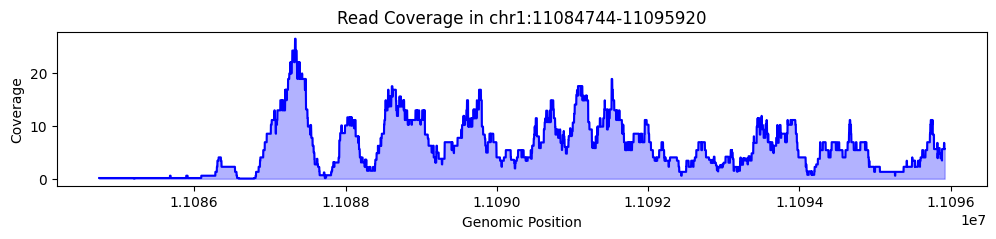

In [13]:
# Plotting the p-value data
plt.figure(figsize=(12, 2))
plt.plot(range(start, end), values, color='blue')
plt.fill_between(range(start, end), values, color='blue', alpha=0.3)
plt.title(f"Read Coverage in {chrom}:{start}-{end}")
plt.xlabel("Genomic Position")
plt.ylabel("Coverage")
plt.show()

![Alt text](ENCFF601VTB_genome_browser.png) <br>

Run the code above to see the values extracted from the ENCFF601VTB bigWig compared to the same region as seen in [UCSC's Genome Browser](https://genome.ucsc.edu/cgi-bin/hgTracks?db=hg38&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr1%3A11084744%2D11095920&hgsid=2307713234_Kap236Tjt6ZGnnNrXMkIhq2Ajn27)

# Example Data Pre-Processing

## Part 1 - Target Values (Y)

Lets say we wanted to predict the coverage from this same experiment (ENCSR817LUF) and ENCSR958TSO, which also targets the H3K36me3 histone. How would the data pre-processing stage look in practice? First we would need to decide our model constants, (e.g. which chromosomes, the input window, output window and prediction resolution), have an array containing chromosome lengths for bin buffer lengths, and bigWig data. For computational reasons, lets go through the process for chromosomes 1 through 3.

In [14]:
# Model constants
INPUT_WINDOW = 2048
OUTPUT_WINDOW = 32
PRED_RES = 32
buffer_bp = (INPUT_WINDOW-OUTPUT_WINDOW)//2


# Model will predict on chromsomes 1
CHROMOSOMES =np.array(['chr1', 'chr2', 'chr3'])


# hg38 chrom lengths
# Human Genome Assembly GRCh38.p14
CHROM_LEN =np.array([248_956_422, 242_193_529, 198_295_559, 190_214_555, 181_538_259, 170_805_979, 
                     159_345_973, 145_138_636, 138_394_717, 133_797_422, 135_086_622, 133_275_309,
                     114_364_328, 107_043_718, 101_991_189, 90_338_345, 83_257_441, 80_373_285,
                     58_617_616, 64_444_167, 46_709_983, 50_818_468])


# URLs of the BigWig files
urls = [
    'https://www.encodeproject.org/files/ENCFF601VTB/@@download/ENCFF601VTB.bigWig',
    'https://www.encodeproject.org/files/ENCFF042SAY/@@download/ENCFF042SAY.bigWig' # p-values from experiment ENCSR958TSO
]

### Function to Process Target Values (Y)

As explained previously, the aim for one snapshot of the input window as it goes over a chromosome, is to average a smaller resolution of base pairs across the center of the input window. This load_y function implements this logic. An arcsinh transformation is included to help deal with diffent sequencing depths as the bigWig data contains p-values.

In [15]:
def load_y(data: dict,#pybigwig object
           labels: list,
           selected_chromosome: chr,
           window_start: int,
           window_size: int,
           target_bp:int,
           pred_res: int):
    
    """Function to load target y values from bigwigs"""
    #get buffer amount between input and output - centre output
    buffer_bp = (window_size-target_bp)//2
    target_length = target_bp//pred_res    
    # Output labels only for selected cells
    all_y = np.zeros(shape=(target_length, len(labels)))
    for i, label in enumerate(labels):
        #data at pred_res bp lvl already but loaded in at 1bp lvl
        #need to avg back up!
        # Data is arcsinh transformed to deal help with different seq depths
        all_y[:, i] = np.arcsinh(np.mean( 
            np.nan_to_num(
                data[label].values(
                    selected_chromosome,
                    window_start+buffer_bp,
                    window_start+buffer_bp+target_bp,
                    numpy=True
                )
            ).reshape(-1, pred_res),#averaging at desired pred_res  
            axis=1))
    return all_y


### Main Script

The 2nd main portion of this code takes a long time to execute eventhough we're going through just three chromosome from two experiments. The data output is saved as a compressed csv file, so there is no need to re-run the code from Main 2. Running Main 1 will give you a sense of what the dna bins look like. In terms of code logic, we create the bins based on the input window size (2048), starting from the buffer (1008) and ending one buffer before the end of a chromosome in order to prevent going past the chromosome indexes. Then we populate the dataframe using our load_y function which transforms our data.

In [16]:
# Main 1

# Create a dict of all bigwigs
bw_dat = {}
for url in urls:
    bw = pyBigWig.open(url)
    if bw is not None:
        bw_dat[url] = bw



# Setting up the dna bins and dataframe
for ind,chrom_i in enumerate(CHROMOSOMES):
    bins = np.arange(buffer_bp,CHROM_LEN[ind]-buffer_bp,INPUT_WINDOW)
    #store in pd df
    if(ind==0):
        dna_bins = pd.DataFrame({
            'chr': chrom_i,
            'pred_strt': bins,
            'pred_end': bins+OUTPUT_WINDOW,
            'dna_strt': bins-buffer_bp,
            'dna_end': bins+OUTPUT_WINDOW+buffer_bp
        })
    else:
        tmp = pd.DataFrame({
            'chr': chrom_i,
            'pred_strt': bins,
            'pred_end': bins+OUTPUT_WINDOW,
            'dna_strt': bins-buffer_bp,
            'dna_end': bins+OUTPUT_WINDOW+buffer_bp
        })
        dna_bins = pd.concat([dna_bins, tmp])
dna_bins = dna_bins.reset_index()
print(dna_bins)

        index   chr  pred_strt   pred_end   dna_strt    dna_end
0           0  chr1       1008       1040          0       2048
1           1  chr1       3056       3088       2048       4096
2           2  chr1       5104       5136       4096       6144
3           3  chr1       7152       7184       6144       8192
4           4  chr1       9200       9232       8192      10240
...       ...   ...        ...        ...        ...        ...
336637  96819  chr3  198286320  198286352  198285312  198287360
336638  96820  chr3  198288368  198288400  198287360  198289408
336639  96821  chr3  198290416  198290448  198289408  198291456
336640  96822  chr3  198292464  198292496  198291456  198293504
336641  96823  chr3  198294512  198294544  198293504  198295552

[336642 rows x 6 columns]


In [ ]:
# Main 2 WARNING THIS CODE BLOCK TAKES A LONG TIME TO RUN AND IS NOT NECESSARY TO COMPLETE THE TUTORIAL


# For each bin, load the data and find the max coverage
cov = []
for index, row in dna_bins.iterrows():
    if(index%20_000==0):
        print(row['chr'] +": "+str(row['pred_strt']))  
    dna_strt = row['dna_strt'] 
    the_chr = row['chr']
    all_y = load_y(data=bw_dat,
                    labels=urls,
                    selected_chromosome=the_chr,
                    window_start=dna_strt,
                    window_size = INPUT_WINDOW,
                    target_bp = OUTPUT_WINDOW,
                    pred_res = PRED_RES)
    #save max coverage
    cov.append(np.max(all_y))

#add cov to data
dna_bins['cov'] = cov



# Save the data as a compressed csv file
'''
dna_bins.to_csv('dnabins/reg_cov_p.csv.gz',
                index=False,compression='gzip')
'''

print(dna_bins)

## Part 2 - X Values, Thresholding, One-Hot-Encoding, and Train/Test Splits

Given our input window size of 2048bp, we have averaged the center 32bps to give us the max coverage, our target values (y). Now we need to collect our X values (DNA) to train our model to predict the target values. As stated previously, the X values are the 2048bp region in the chromosome, e.g. dna_strt - dna_end. Because these ENCODE bigWigs have already been alligned to a reference genome, we can retrieve these 2048bp regions as DNA sequences (A, C, T, and Gs,) using the reference genome hg38. For our model, we'll one-hot-encode these sequences, and split the data into training, validation and test sets saved as npz files for ease of loading the data into a model later.

The reference genome data is located in this repo (data/hg38_reference_genome/hg38.fa) but can be downlaoded from the following UCSC link <br>(http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz) using "wget -O" on the command line <br>

wget -O - http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz | gunzip -c > hg38.fa


### Thresholding

We'll begin by loading our dna_bins from the previous part and undergo thresholding. The threshold value of 2 is chosen in consistency with [a previous genomic study](https://www.nature.com/articles/s42256-022-00570-9) on evaluating deep learning for predicting epigenomic profiles. We aim to only select bins with max coverage values over this threshold to train our model. 

In [17]:
# Load our DNA bins filled with our target values
dna_bins = pd.read_csv('dnabins/reg_cov_p.csv.gz')

# Set a threshold to filter our data
threshold = 2
threshold = np.arcsinh(threshold) # The threshold has to undergo an arcsinh transformation as well

filt_dna_bins = dna_bins.loc[dna_bins['cov']>threshold].reset_index(drop=True) # Apply the threshold 

print(f"{filt_dna_bins.shape[0]} training/validation/test positions.")


30446 training/validation/test positions.


### Function for One-Hot-Encoding

The aim of this function is to one-hot-encode a sequence of A, C, T, and Gs from the reference genome hg38. The function returns a numpy array of shape (sequence_length, 4). Note that the code handles 'N' as a special case and sets all bases for that nucelotide to False/0.

In [18]:
def one_hot_encode_sequence(sequence: str) -> np.ndarray:
    """
    Function to one-hot encode a given DNA sequence.

    Parameters:
    - sequence (str): The DNA sequence consisting of nucleotides 'A', 'C', 'G', 'T', 'N' 

    """
    # Convert the sequence to uppercase
    sequence = sequence.upper()
    
    # Define nucleotide mapping
    nucleotide_mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

    # Initialize the one-hot encoded matrix with zeros
    one_hot_matrix = np.zeros((len(sequence), len(nucleotide_mapping)), dtype=int)

    for i, nucleotide in enumerate(sequence):
        if nucleotide in nucleotide_mapping:
            one_hot_matrix[i, nucleotide_mapping[nucleotide]] = 1
        elif nucleotide == 'N':
            # 'N' case: all zeros
            continue
        else:
            raise ValueError(f"Invalid nucleotide '{nucleotide}' in the sequence.")

    return one_hot_matrix

### Training/Validation/Test Splits

In order to prepare our data for a machine learning model, we need training, validation and test splits. The key point of the function is that we are splitting by chromosome. Splitting by chromosomes ensures that regions from the same chromosome are not split across training, validation, and test sets. This preserves the genomic context and avoids data leakage where information from the same chromosome might inadvertently influence multiple splits. If genomic regions from the same chromosome are in both training and test sets, it could lead to overfitting or biased evaluation, and this ensures each split is independent. Several pitfalls of machine learning in genomics will be discussed in further tutorials.

The function first selects a set of chromosomes to include in the test set based on the desired coverage fraction. Once a chromosome is selected for the test set, it is removed from the list of available chromosomes for subsequent sets. This is then repeated for the validation set, and the remaining chromosomes are used for the training set. As we are only using 3 chromosomes, I have increased the tolerance for the splits to allow for the split.

In [19]:
def train_valid_test_split(dat, valid_frac=0.2, test_frac=0.2,tol=0.001):
    """
    Function to create a train validatin test split between chromosomes.
    Takes all training regions and splits to give proportions based on
    user selected.
    """
    #get the coverage filtered dataset to group by chrom and get num entries
    counts_chroms = dat.groupby('chr')['cov'].count().reset_index()
    counts_chroms['prop'] = counts_chroms['cov']/counts_chroms['cov'].sum()
    
    def sample_set(counts_chroms,frac = 0.2,tol=0.025):
        #make a copy so can reset
        counts_chroms_ = counts_chroms.copy()
        reset_count=0
        act_frac=0
        sample_chr=[]
        while abs(act_frac-frac)>tol:
            #if gone to high, start again
            if act_frac>frac:
                sample_chr=[]
                act_frac=0
                counts_chroms_ = counts_chroms.copy()
                reset_count+=1
                assert reset_count<100, f"Can't find a combination for {frac} proportion!"
            else:
                #sample rand chrom
                chr_rand = random.randrange(counts_chroms_.shape[0])
                sample_chr.append(counts_chroms_.loc[chr_rand]['chr'])
                act_frac+=counts_chroms_.loc[chr_rand]['prop']
                counts_chroms_ = counts_chroms_.drop(index=[chr_rand]).reset_index(drop=True)
        return(counts_chroms_,sample_chr,act_frac)
    #get test set
    counts_chroms,test_chr,test_act = sample_set(counts_chroms,frac = test_frac,tol=tol)
    #get valid set
    counts_chroms,valid_chr,valid_act = sample_set(counts_chroms,frac = valid_frac,tol=tol)
    #train - remainder
    train_chr = counts_chroms['chr'].tolist()
    train_act = counts_chroms['prop'].sum()
    
    return({"train":train_chr,"valid":valid_chr,"test":test_chr},
           {"train":train_act,"valid":valid_act,"test":test_act}
           )

chrom_split,props = train_valid_test_split(filt_dna_bins, valid_frac=0.2, test_frac=0.2,tol=0.14)
print(chrom_split)
print(props)

{'train': ['chr1'], 'valid': ['chr3'], 'test': ['chr2']}
{'train': np.float64(0.4099389082309663), 'valid': np.float64(0.25898311765092297), 'test': np.float64(0.33107797411811074)}


### Putting It All Together Into .npz Files

Due to computational limitations, the reference genome hg38 is accessed using Ensembl's REST API. However it is recommended that all data, including the reference genome is downloaded locally. When downloaded locally, saving the reference genome as a variable is simple using the .Fastafile(path) method from the Pysam library. Accessing a region is as simple using Pysam's .fetch(chr, start, end) method. 

Following on, we'll use a random seed for reproducibility of the splits. We'll call our train/valid/test function to split our filtered dna bins, adding the split as a column to the data. Initialising a counters dictionary to keep track, for each row in the data (representing an input window size region), we'll call our one-hot-encode function to encode the 2048bp region. Finally, within this for loop, we'll save each file as an .npz file by their split and counter. 

For this example, I have chosen to break the loop after one .npz split is saved.

In [20]:
def genome_dat(chromosome, start, end):
    start = start + 1 # Not including start bp, Pysam.fetch by default does not include the start bp. 
    
    url = f'https://rest.ensembl.org/sequence/region/human/{chromosome}:{start}..{end}?content-type=text/x-fasta'
    response = requests.get(url)
    
    if response.ok:
        no_header = response.text
        # Process the FASTA text to remove the header line
        lines = no_header.split('\n')
        # Skip the first line (header) and join the remaining lines to form the sequence
        sequence_lines = lines[1:]  # This excludes the header
        sequence = ''.join(sequence_lines)
        return sequence
    else:
        response.raise_for_status()
        
# Using the Pysam library
# genome_dat = pysam.Fastafile('path/to/downloaded/reference_genome') 



#get consistent train, valid, test split
random.seed(101)

chrom_split,props = train_valid_test_split(filt_dna_bins, valid_frac=0.2, test_frac=0.2,tol=0.14)
#add split column to dat
for i in ['train','valid','test']:
    filt_dna_bins.loc[filt_dna_bins['chr'].isin(chrom_split[i]),'split']=i

# Now load and save the data as a np obj
counters = {"train":0,"valid":0,"test":0}

loop_once_for_example = False #

for index, row in filt_dna_bins.iterrows():

    if loop_once_for_example:
        break
    
    if(index%5_000==0 and index!=0):
            print(row['chr'] +": "+str(row['pred_strt']))
    split = row['split']
    dna_strt = row['dna_strt'] 
    dna_end = row['dna_end'] 
    the_chr = row['chr']
    all_y = load_y(data=bw_dat,
                       labels=urls,
                       selected_chromosome=the_chr,
                       window_start=dna_strt,
                       window_size = INPUT_WINDOW,
                       target_bp = OUTPUT_WINDOW,
                       pred_res = PRED_RES)
    # Add the one-hot-encoded X values for the split region
    X = one_hot_encode_sequence(genome_dat(the_chr, dna_strt, dna_end))
    # X = one_hot_encode_sequence(genome_dat.fetch(the_chr, dna_strt, dna_end)) Using Pysam Library

    
# Save each split as a .npz file

    np.savez(f'example_training_datasplit/{split}_{counters[split]}.npz', 
        X=X,
        y=all_y)

# Increment counter
    counters[split]+=1

    loop_once_for_example = True

## Results

Based on data from 3 chromosomes from 2 experiments, going through the process in full would result in 30446 training/validation/test positions available to load into a model. Each position has one-hot-encoded X values of shape (2048, 4) and coverage Y values of shape (1, 2) as seen below. Due to the large amount of splits, it is common to use a dataloader such as the PyTorch library DataLoader to handle batching, shuffling, and batch sizes. 

In [21]:
data = np.load("example_training_datasplit/train_0.npz")
for key in data.files:
    print(f"Key: {key}")
    print(f"Array shape: {data[key].shape}")
    print(data[key])

Key: X
Array shape: (2048, 4)
[[0 0 1 0]
 [1 0 0 0]
 [0 0 1 0]
 ...
 [1 0 0 0]
 [1 0 0 0]
 [0 0 1 0]]
Key: y
Array shape: (1, 2)
[[1.93196297 0.38099957]]
